Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [1]:
from random import random, seed
from itertools import product
import numpy as np

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
UNIVERSE_SIZE = None
NUM_SETS = None
DENSITY = None
rng = None

def generate_universe(universe_size, num_sets, density):
    global UNIVERSE_SIZE, NUM_SETS, DENSITY, rng
    
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [3]:
SETS = None
COSTS = None

def generate_instance():
    global SETS, COSTS
    # DON'T EDIT THESE LINES!
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [5]:
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate

d:\Università\Computational Intelligence\CI2024_lab1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tweak
I use a single mutation tweak, which performs better than the multiple mutation one. I keep track of the number of sets in which each element is contained, and do not allow to go back to an invalid solution

In [6]:
def single_mutation(solution, elements):
    new_solution = solution.copy()
    index = np.random.randint(0, NUM_SETS)

    new_solution[index] = not new_solution[index]

    diff = 2*new_solution[index] - 1

    if COSTS[index] <=1:
        return solution

    if diff==-1 and np.sum(elements[SETS[index]]<=1) > 0:
        return solution
    
    elements += diff*SETS[index]

    return new_solution

def multiple_mutations(solution, elements, strength: float = 0.3): # single mutation performs better
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[rng.random.randint(NUM_SETS)] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

tweak=single_mutation

## Fitness
I maximize `(coverage,-cost)`, to make computation faster I use a support array

In [7]:
def num_elements(solution): # this solution is computationally expensive, so I did not use it in the final code
    x =np.logical_or.reduce(SETS[solution])
    return x.sum()

def fitness(solution, elements):
    return (np.sum(elements>0), -cost(solution))

## Hill climber
Starting from a random solution, I try to maximize the fitness.

I keep track of the coverage in an array to make computation faster.

In [8]:
def find_solution(MAX_STEPS):
    start_solution = rng.random(NUM_SETS) < 0.5
    solution = start_solution
    elements = SETS[solution].sum(axis=0)
    solution_fitness = fitness(solution, elements)
    history = [solution_fitness]

    ic(solution_fitness, valid(solution))
    prev_elements = elements.copy()

    best = 0
    for n in tqdm(range(MAX_STEPS)):
        new_solution = tweak(solution, elements)
        f= fitness(new_solution, elements)
        history.append(f)
        if f > solution_fitness:
            solution = new_solution
            solution_fitness = f
            best = n
        else:
            elements = prev_elements
        prev_elements = elements.copy()
    ic(solution_fitness, valid(solution), best)
    return solution, history

In [9]:
def plot_solution(history):
    fitness_0 = [f[0] for f in history]
    first_valid_index = next(i for i, v in enumerate(fitness_0) if v == UNIVERSE_SIZE)
    fitness_1 = [f[1] for f in history]

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(first_valid_index),
        np.full(first_valid_index,fitness_1[first_valid_index]),
        color="red",
        linestyle="--"
    )
    plt.plot(
        range(first_valid_index, len(fitness_1)),
        list(accumulate(fitness_1[first_valid_index:], max)),
        color="red",
    )

    plt.scatter(range(len(fitness_1)), fitness_1, marker=".")

    plt.title(f"UNIVERSE_SIZE={UNIVERSE_SIZE}, NUM_SETS={NUM_SETS}, DENSITY={DENSITY}")
    plt.show()

# Solution

ic| UNIVERSE_SIZE: 100, NUM_SETS: 10, DENSITY: 0.2, MAX_STEPS: 100
ic| solution_fitness: (np.int64(66), np.float64(-118.78870005253899))
    valid(solution): np.False_
100%|██████████| 100/100 [00:00<00:00, 6002.15it/s]
ic| solution_fitness: (np.int64(100), np.float64(-277.732253032823))
    valid(solution): np.True_
    best: 18


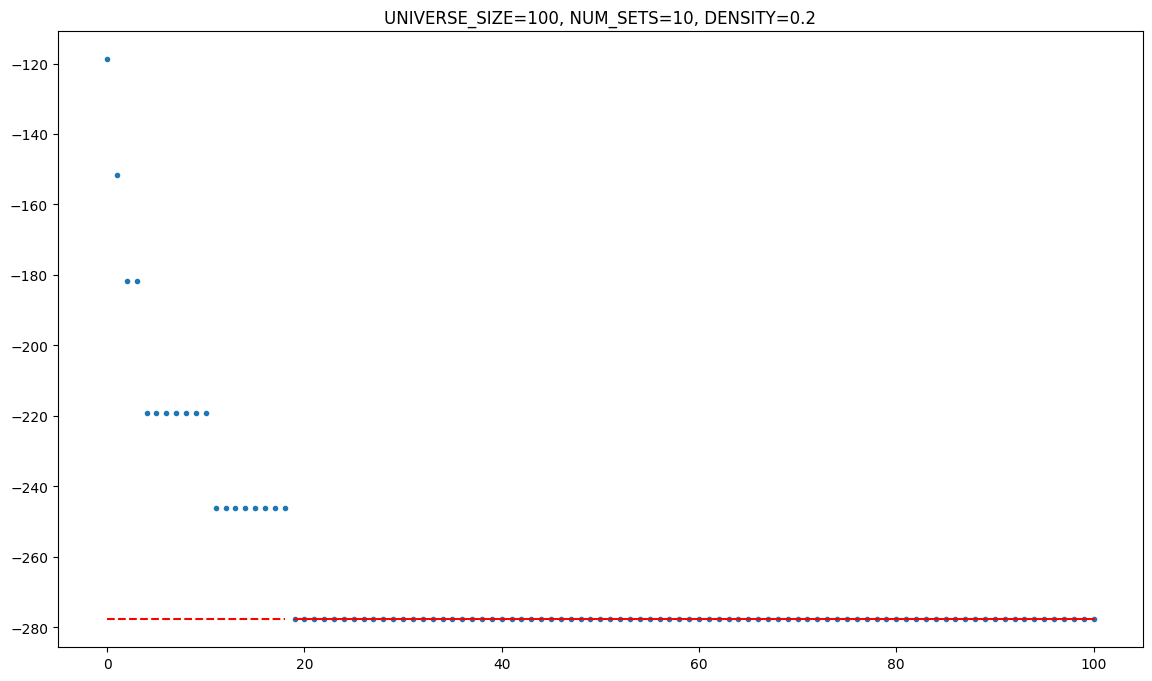

ic| UNIVERSE_SIZE: 1000, NUM_SETS: 100, DENSITY: 0.2, MAX_STEPS: 1000
ic| solution_fitness: (np.int64(1000), np.float64(-15960.478393905527))
    valid(solution): np.True_
100%|██████████| 1000/1000 [00:00<00:00, 20629.48it/s]
ic| solution_fitness: (np.int64(1000), np.float64(-6515.505652835335))
    valid(solution): np.True_
    best: 384


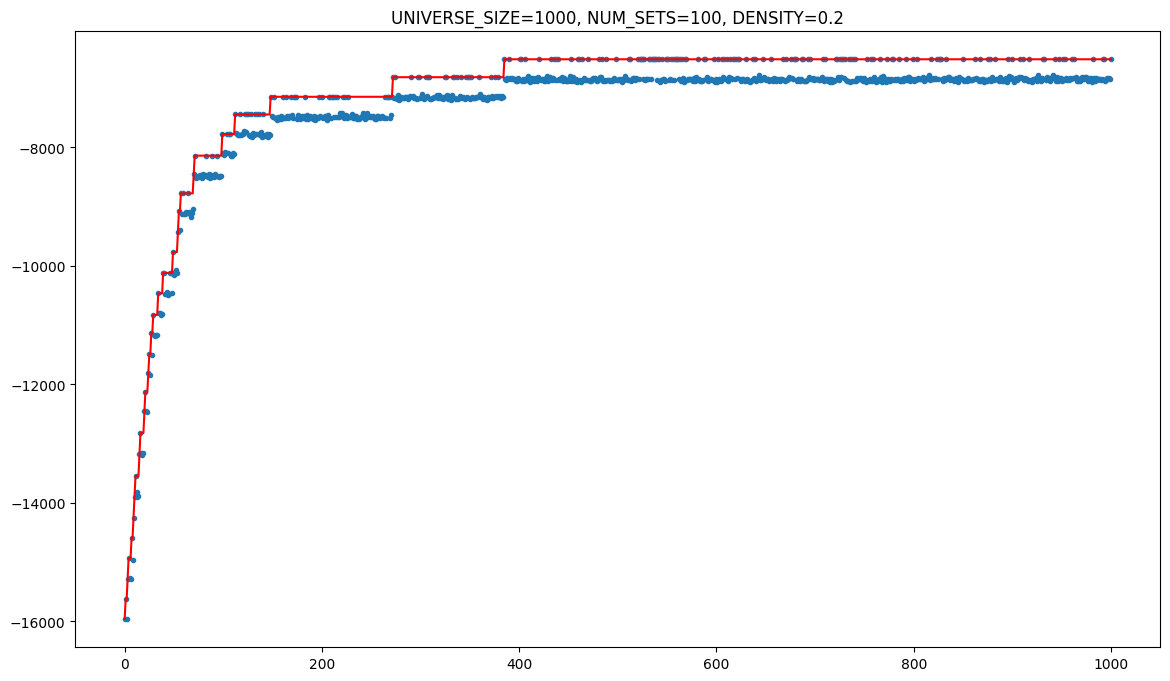

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    MAX_STEPS: 10000
ic| solution_fitness: (np.int64(10000), np.float64(-2142558.3101055752))
    valid(solution): np.True_
100%|██████████| 10000/10000 [00:00<00:00, 14637.94it/s]
ic| solution_fitness: (np.int64(10000), np.float64(-133023.89729403716))
    valid(solution): np.True_
    best: 3388


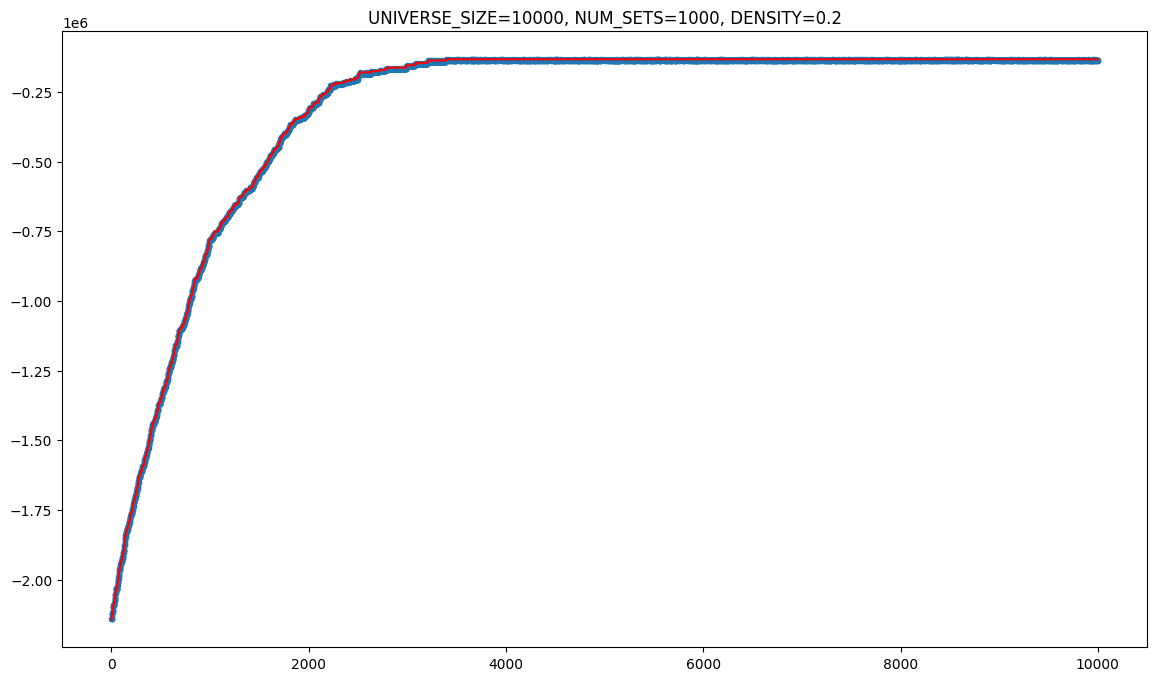

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    MAX_STEPS: 100000
ic| solution_fitness: (np.int64(100000), np.float64(-124560133.24194363))
    valid(solution): np.True_
100%|██████████| 100000/100000 [01:03<00:00, 1580.44it/s]
ic| solution_fitness: (np.int64(100000), np.float64(-1960565.4334978575))
    valid(solution): np.True_
    best: 65569


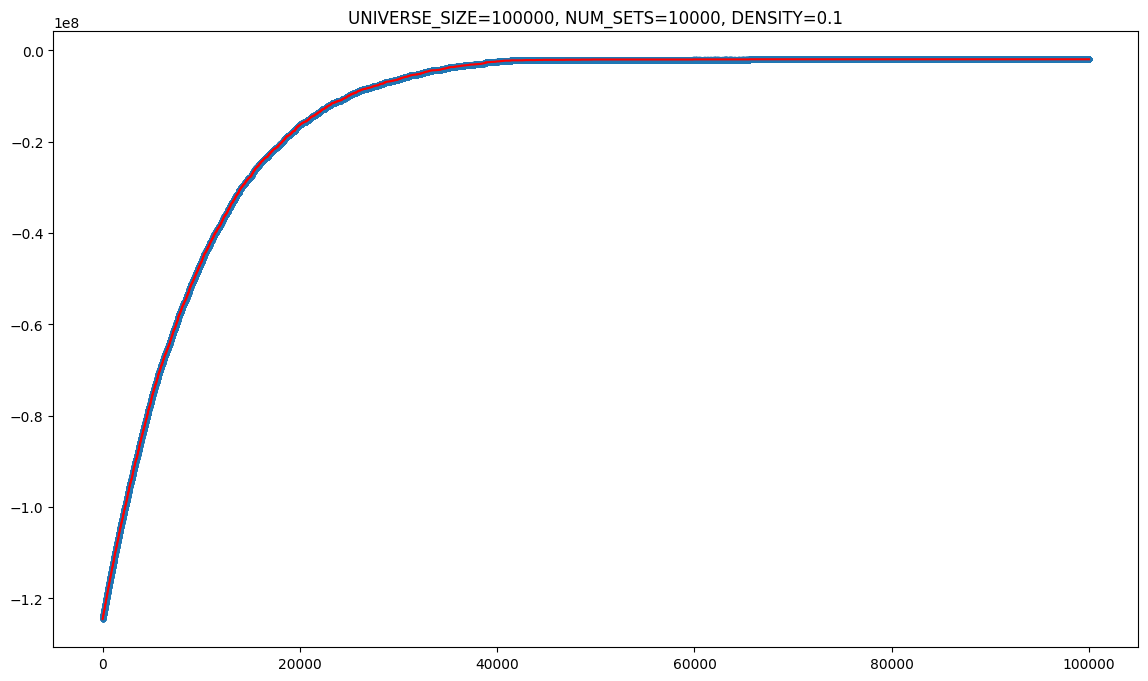

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    MAX_STEPS: 100000
ic| solution_fitness: (np.int64(100000), np.float64(-268517274.66605204))
    valid(solution): np.True_
100%|██████████| 100000/100000 [00:55<00:00, 1817.96it/s]
ic| solution_fitness: (np.int64(100000), np.float64(-2209460.3996252455))
    valid(solution): np.True_
    best: 59122


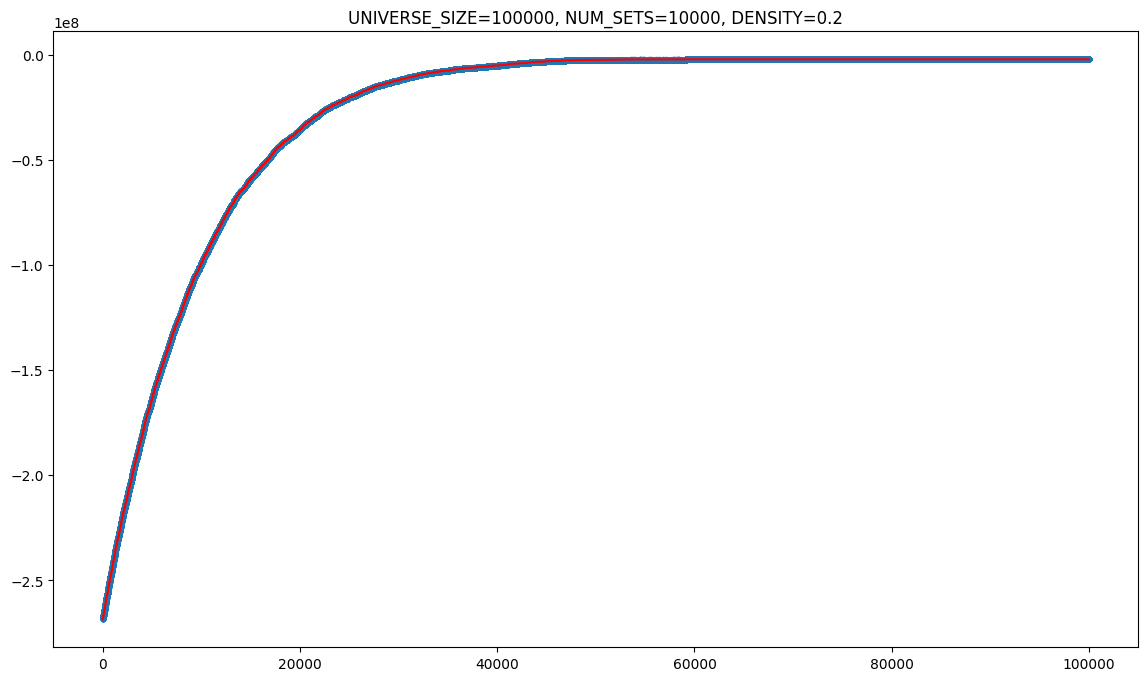

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    MAX_STEPS: 100000
ic| solution_fitness: (np.int64(100000), np.float64(-423422977.2294674))
    valid(solution): np.True_
100%|██████████| 100000/100000 [00:47<00:00, 2123.06it/s]
ic| solution_fitness: (np.int64(100000), np.float64(-2188214.770356963))
    valid(solution): np.True_
    best: 58319


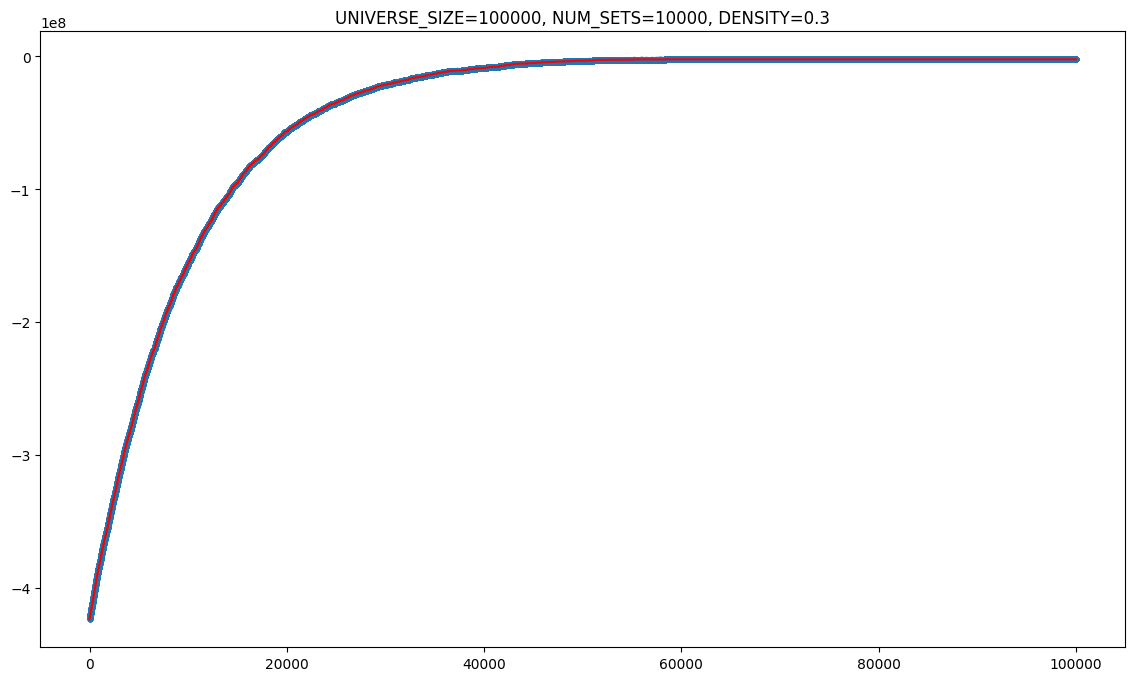

In [10]:
for(UNIVERSE_SIZE, NUM_SETS, DENSITY, MAX_STEPS) in [(100,10,0.2,100),(1000, 100, 0.2, 1000), (10000, 1000, 0.2, 10000), (100000, 10000, 0.1, 100000), (100000, 10000, 0.2, 100000), (100000, 10000, 0.3, 100000)]:
    ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, MAX_STEPS)

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

    # Generating the sets
    generate_instance()

    # Finding the solution
    solution, history=find_solution(MAX_STEPS)

    # Plotting
    plot_solution(history)

None

# Final results
|INSTANCE|UNIVERSE SIZE |NUM SETS  |DENSITY  | STEPS  | FITNESS CALLS | COST | EXECUTION TIME (mm:ss) |
|-|-------------|----------|---------|-----------|--|--|--|
|1|100          |10        |0.2      |18       |19 | 277.732253032823|00:00 |
|2|1000 | 100 | 0.2 | 384 |385| 6515.505652835335 | 00:00|
|3|10000 | 1000 | 0.2 | 3388 |3389| 133023.89729403716 | 00:00|
|4|100000 | 10000 | 0.1 | 65569 |65570| 1960565.4334978575| 01:03 |
|5|100000 | 10000 | 0.2 | 59122 |59123| 2209460.3996252455| 00:55 |
|6|100000 | 10000 | 0.3 | 58319 |58320| 2188214.770356963|00:47 |


Some chatting and discussion with [Michele Cazzola](https://github.com/MicheleCazzola/CI2024_lab1)